In [4]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
ruta = '/home/rich12/Nube/Tesis/Final_23_03_23_Resultados/Escenarios/Escenario_1 (aumento en densidad)'
#archivo_py = 'Funciones_campo_B.py'#para A_SEH
archivo_py = 'Funciones.py'
ruta_funciones = PurePath(Path(ruta), Path(archivo_py))
%run -i "{ruta_funciones}" #funciones importantes

#Latex y coma como separador decimal
plt.rcParams['text.usetex'] = True #latex
#plt.rc('text', usetex=False)
plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
#se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx} \sisetup{output-decimal-marker = {,}}') 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

import locale #líbreria para el formato
locale.setlocale(locale.LC_ALL, "es_CR.utf8")

'es_CR.utf8'

(98, 40, 48)


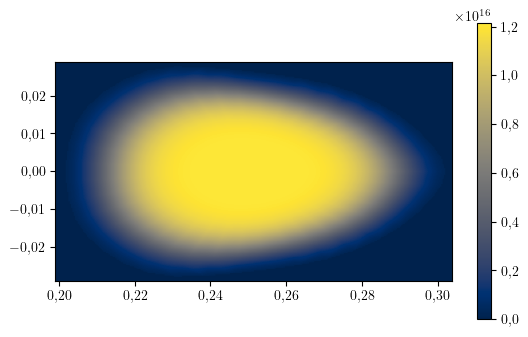

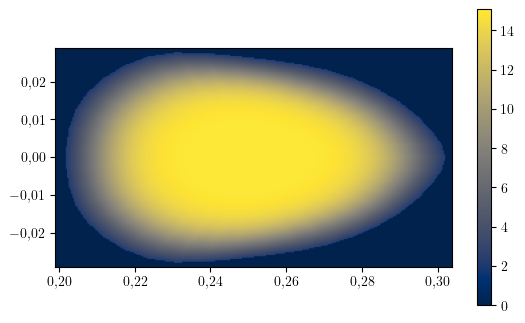

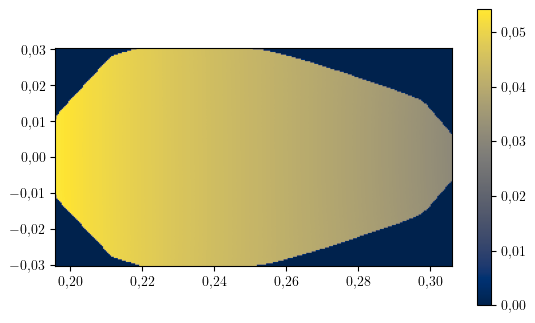

In [5]:
ruta_campo = PurePath(Path(ruta), Path('ne_Te_r_z_B/r+z+B_mag_componentes.txt'))
ruta_ne = PurePath(Path(ruta), Path('ne_Te_r_z_B/densidad.txt'))
ruta_Te = PurePath(Path(ruta), Path('ne_Te_r_z_B/temperatura.txt'))

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec(PurePath(Path(ruta), Path('input_VMEC')), 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

6.140375029682791


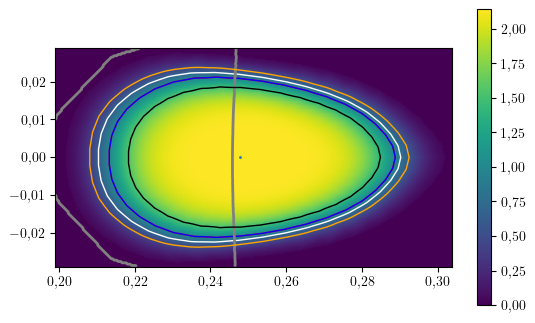

In [10]:
#Frecuencias
from scipy.constants import e, m_e, epsilon_0 #constantes físicas

#Constantes
f_calentamiento = 2.45e9
omega =  2*np.pi*f_calentamiento
n_corte = (m_e*epsilon_0*np.power(omega,2))/(np.power(e,2))

#Factor para un núcleo con un corte muy cerca del núcleo
factor_densidad1 = n_corte/np.max(ne_interpol)
print(factor_densidad1)
#factor_densidad = 6.1405*1.48
#factor_densidad = 6.1405*1.85
factor_densidad = 6.1405*2.14

#campo magnético neto
B_neto = np.sqrt( np.power(B_xint,2) + np.power(B_yint,2) + np.power(B_zint,2) ) 
factor_B = 1

#Malla
grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] #cero grados - bsolctra solo 1000

#Frecuencia ciclotrónica electrónica
wce = ((e)/(m_e))*B_neto

#Frecuencia ciclotrónica electrónica normalizada
wec_norm = ((e)/(m_e*omega))*(factor_B*B_neto)

#Frecuencia del plasma electrónica
wpe = ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
wpe_norm = np.sqrt( ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) )/omega


#Frecuencia híbrida superior normalizada --- Debe coincidir los valores de n_e y B interpolados
wuh_norm = (np.sqrt(np.power(wce,2) + wpe))/omega 
#print(np.max(wuh_norm))

#Densidad electrónica normalizada
ne_norm = (factor_densidad*ne_interpol)/n_corte
np.savetxt('ne_norm_ang.txt', ne_norm, header='ne_normalizada', delimiter=' ', fmt='%f') #normalizada

#onda R
wR = 0.5 * (wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wR_norm = wR/omega

#onda L
wL = 0.5 * (-wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wL_norm = wL/omega
#print(np.nonzero(wR_norm)[0])

#Exportar para el archivo output
#np.savetxt('wuh_A_SEH.txt',  wuh_norm , header='wuh_normalizada', delimiter=' ', fmt='%f') #quitar notación científica
#np.savetxt('wuh_#.txt',  wuh_norm , header='wuh_normalizada', delimiter=' ', fmt='%f') #quitar notación científica
#np.savetxt('ne_norm.txt', ne_norm, header='ne_normalizada', delimiter=' ', fmt='%f') #normalizada
#np.savetxt('ne_norm_ang.txt', ne_norm, header='ne_normalizada', delimiter=' ', fmt='%f') #normalizada
#np.savetxt('wR_norm.txt', wR_norm, header='wR_normalizada', delimiter=' ', fmt='%f') #normalizada
#np.savetxt('wec_norm.txt', wec_norm , header='wec_normalizada', delimiter=' ', fmt='%f') # normalizada
#np.savetxt('wL_norm.txt', wL_norm, header='wL_normalizada', delimiter=' ', fmt='%f') #normalizada

#Gráficos
levels = np.arange(1.0, 1.01, 1) #O mode cut-off
levels1 = np.arange(0.5,0.501, 0.5) # frecuencia de la onda incidente es la mitad de la frecuencia ciclotrónica electrónica

#contour plots
cmap= "viridis"
dc = plt.imshow(np.flipud(ne_norm.T), extent=(0.19893,0.303797,-0.0289025,0.0289019), cmap = cmap) #density contour map for matplot lib for python
omode = plt.contour(grid_r,grid_z,  ne_norm, levels, linestyles = 'solid', colors = 'red', linewidths = 1) # to plot the contour
uh = plt.contour(grid_r,grid_z, wuh_norm, levels, linestyles = 'solid', colors = 'white', linewidths = 1)
pe = plt.contour(grid_r,grid_z, wpe_norm, levels, linestyles = 'solid', colors = 'blue', linewidths = 1)
ce = plt.contour(grid_r,grid_z, wec_norm, levels1, linestyles = 'solid', colors = 'gray', linewidths =2)
R = plt.contour(grid_r,grid_z,  wR_norm, levels, linestyles = 'solid', colors = 'orange', linewidths =1)
L = plt.contour(grid_r,grid_z,  wL_norm, levels, linestyles = 'solid', colors = 'black', linewidths =1)
ac = plt.colorbar(dc, orientation='vertical', shrink=0.8)
plt.scatter([0.2478], [0],s=1 )
plt.gca().set_aspect("equal")
